In [1]:
import gdal 
from osgeo import gdal 
from numpy import *

import matplotlib.pyplot as plt 
%matplotlib inline

import rasterio 
from rasterio import plot

from rasterio.plot import show

In [2]:
from osgeo import gdal, gdalnumeric, ogr
from PIL import Image, ImageDraw
import os
import numpy as np

def clip_raster(rast, features_path, gt=None, nodata=-9999):
    '''
    Clips a raster (given as either a gdal.Dataset or as a numpy.array
    instance) to a polygon layer provided by a Shapefile (or other vector
    layer). If a numpy.array is given, a "GeoTransform" must be provided
    (via dataset.GetGeoTransform() in GDAL). Returns an array. Clip features
    must be a dissolved, single-part geometry (not multi-part). Modified from:

    http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    #clip-a-geotiff-with-shapefile

    Arguments:
        rast            A gdal.Dataset or a NumPy array
        features_path   The path to the clipping features
        gt              An optional GDAL GeoTransform to use instead
        nodata          The NoData value; defaults to -9999.
    '''
    def array_to_image(a):
        '''
        Converts a gdalnumeric array to a Python Imaging Library (PIL) Image.
        '''
        i = Image.fromstring('L',(a.shape[1], a.shape[0]),
            (a.astype('b')).tostring())
        return i

    def image_to_array(i):
        '''
        Converts a Python Imaging Library (PIL) array to a gdalnumeric image.
        '''
        a = gdalnumeric.fromstring(i.tobytes(), 'b')
        a.shape = i.im.size[1], i.im.size[0]
        return a

    def world_to_pixel(geo_matrix, x, y):
        '''
        Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
        the pixel location of a geospatial coordinate; from:
        http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
        '''
        ulX = geo_matrix[0]
        ulY = geo_matrix[3]
        xDist = geo_matrix[1]
        yDist = geo_matrix[5]
        rtnX = geo_matrix[2]
        rtnY = geo_matrix[4]
        pixel = int((x - ulX) / xDist)
        line = int((ulY - y) / xDist)
        return (pixel, line)

    # Can accept either a gdal.Dataset or numpy.array instance
    if not isinstance(rast, np.ndarray):
        gt = rast.GetGeoTransform()
        rast = rast.ReadAsArray()

    # Create an OGR layer from a boundary shapefile
    features = ogr.Open(features_path)
    if features.GetDriver().GetName() == 'ESRI Shapefile':
        lyr = features.GetLayer(os.path.split(os.path.splitext(features_path)[0])[1])

    else:
        lyr = features.GetLayer()

    # Get the first feature
    poly = lyr.GetNextFeature()

    # Convert the layer extent to image pixel coordinates
    minX, maxX, minY, maxY = lyr.GetExtent()
    ulX, ulY = world_to_pixel(gt, minX, maxY)
    lrX, lrY = world_to_pixel(gt, maxX, minY)

    # Calculate the pixel size of the new image
    pxWidth = int(lrX - ulX)
    pxHeight = int(lrY - ulY)

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # In such a case... ulY ends up being negative--can't have that!
        iY = ulY
        ulY = 0

    # Multi-band image?
    try:
        clip = rast[:, ulY:lrY, ulX:lrX]

    except IndexError:
        clip = rast[ulY:lrY, ulX:lrX]

    # Create a new geomatrix for the image
    gt2 = list(gt)
    gt2[0] = minX
    gt2[3] = maxY

    # Map points to pixels for drawing the boundary on a blank 8-bit,
    #   black and white, mask image.
    points = []
    pixels = []
    geom = poly.GetGeometryRef()
    pts = geom.GetGeometryRef(0)

    for p in range(pts.GetPointCount()):
        points.append((pts.GetX(p), pts.GetY(p)))

    for p in points:
        pixels.append(world_to_pixel(gt2, p[0], p[1]))

    raster_poly = Image.new('L', (pxWidth, pxHeight), 1)
    rasterize = ImageDraw.Draw(raster_poly)
    rasterize.polygon(pixels, 0) # Fill with zeroes

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # The clip features were "pushed down" to match the bounds of the
        #   raster; this step "pulls" them back up
        premask = image_to_array(raster_poly)
        # We slice out the piece of our clip features that are "off the map"
        mask = np.ndarray((premask.shape[-2] - abs(iY), premask.shape[-1]), premask.dtype)
        mask[:] = premask[abs(iY):, :]
        mask.resize(premask.shape) # Then fill in from the bottom

        # Most importantly, push the clipped piece down
        gt2[3] = maxY - (maxY - gt[3])

    else:
        mask = image_to_array(raster_poly)

    # Clip the image using the mask
    try:
        clip = gdalnumeric.choose(mask, (clip, nodata))

    # If the clipping features extend out-of-bounds and BELOW the raster...
    except ValueError:
        # We have to cut the clipping features to the raster!
        rshp = list(mask.shape)
        if mask.shape[-2] != clip.shape[-2]:
            rshp[0] = clip.shape[-2]

        if mask.shape[-1] != clip.shape[-1]:
            rshp[1] = clip.shape[-1]

        mask.resize(*rshp, refcheck=False)

        clip = gdalnumeric.choose(mask, (clip, nodata))

    return (clip, ulX, ulY, gt2)

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019244.h10v04.001.2019245111344.h5.tiff
2019-09-01


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


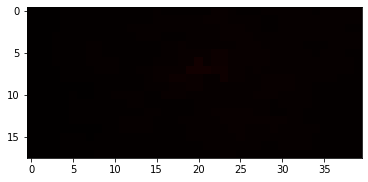

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019245.h10v04.001.2019246122926.h5.tiff
2019-09-02


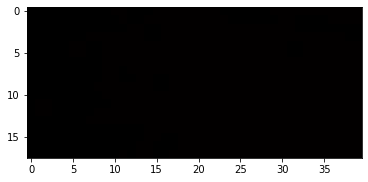

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019246.h10v04.001.2019247101056.h5.tiff
2019-09-03


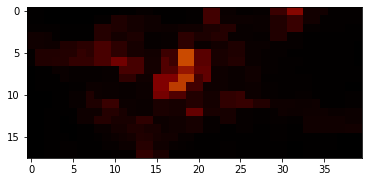

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019247.h10v04.001.2019248093445.h5.tiff
2019-09-04


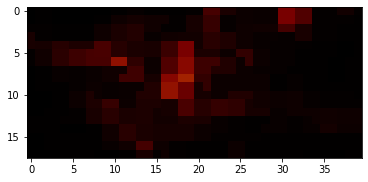

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019248.h10v04.001.2019249102456.h5.tiff
2019-09-05


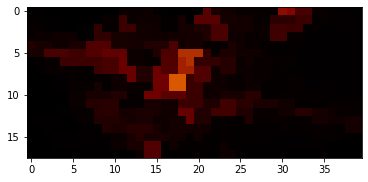

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019249.h10v04.001.2019250150430.h5.tiff
2019-09-06


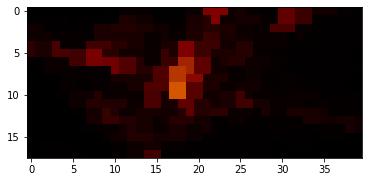

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019250.h10v04.001.2019251095812.h5.tiff
2019-09-07


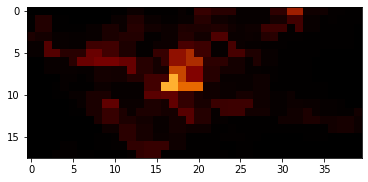

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019251.h10v04.001.2019252100355.h5.tiff
2019-09-08


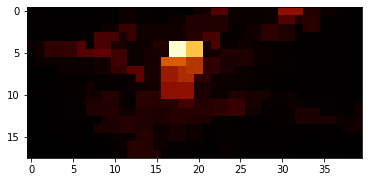

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019254.h10v04.001.2019255203824.h5.tiff
2019-09-11


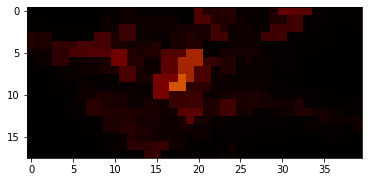

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019255.h10v04.001.2019257023850.h5.tiff
2019-09-12


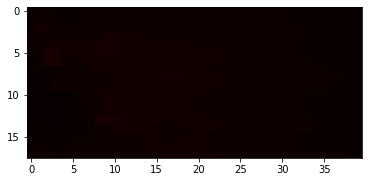

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019256.h10v04.001.2019257150136.h5.tiff
2019-09-13


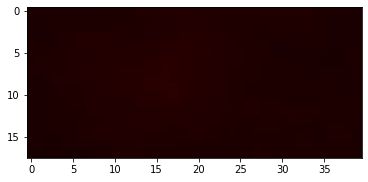

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019257.h10v04.001.2019258144621.h5.tiff
2019-09-14


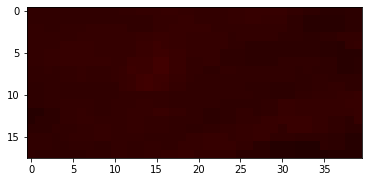

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019258.h10v04.001.2019259131932.h5.tiff
2019-09-15


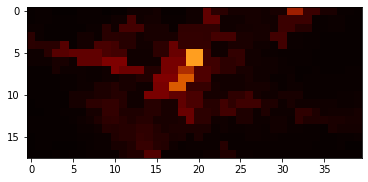

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019260.h10v04.001.2019261102655.h5.tiff
2019-09-17


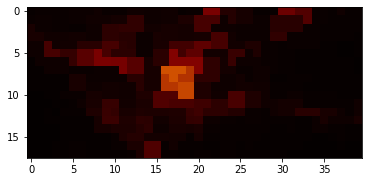

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019261.h10v04.001.2019262130603.h5.tiff
2019-09-18


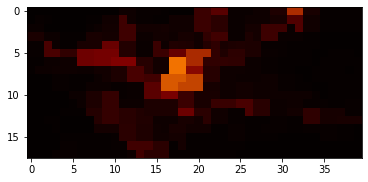

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019262.h10v04.001.2019263105115.h5.tiff
2019-09-19


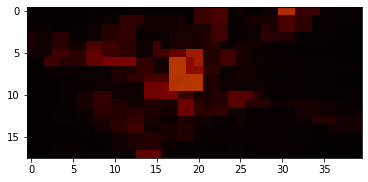

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019263.h10v04.001.2019264093826.h5.tiff
2019-09-20


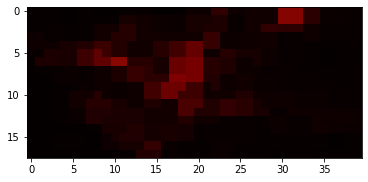

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019265.h10v04.001.2019266113843.h5.tiff
2019-09-22


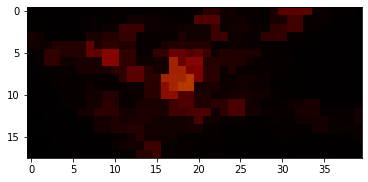

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019266.h10v04.001.2019267101219.h5.tiff
2019-09-23


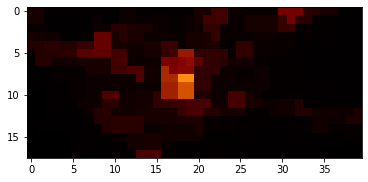

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019268.h10v04.001.2019269104426.h5.tiff
2019-09-25


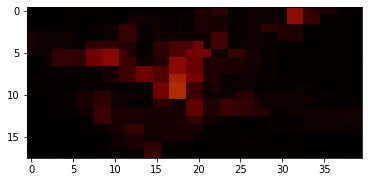

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019269.h10v04.001.2019276210414.h5.tiff
2019-09-26


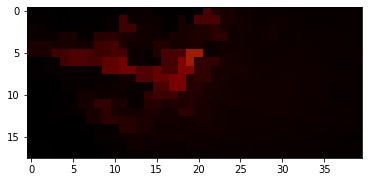

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019270.h10v04.001.2019271121004.h5.tiff
2019-09-27


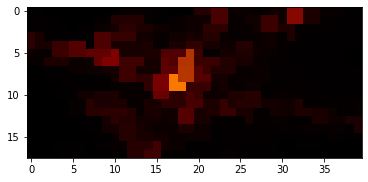

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019271.h10v04.001.2019272100535.h5.tiff
2019-09-28


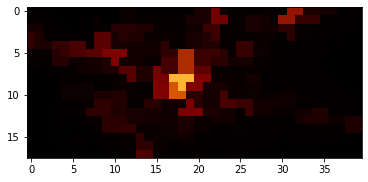

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019274.h10v04.001.2019275070356.h5.tiff
2019-10-01


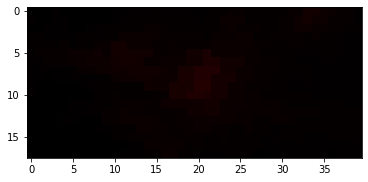

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019275.h10v04.001.2019276090856.h5.tiff
2019-10-02


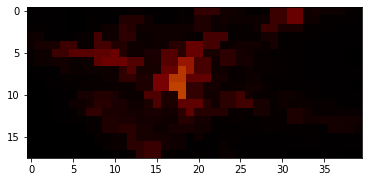

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019277.h10v04.001.2019278081449.h5.tiff
2019-10-04


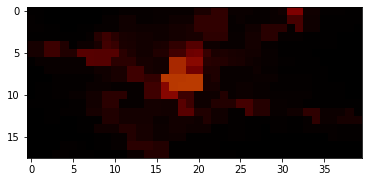

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019278.h10v04.001.2019279085508.h5.tiff
2019-10-05


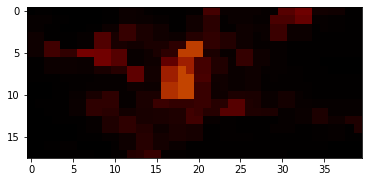

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019279.h10v04.001.2019280080045.h5.tiff
2019-10-06


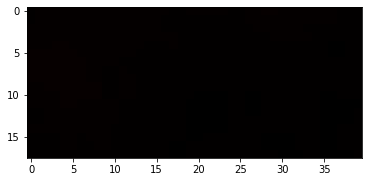

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019281.h10v04.001.2019282091640.h5.tiff
2019-10-08


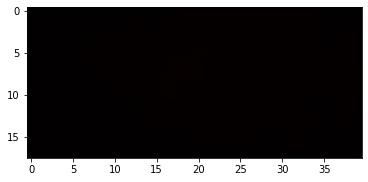

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019282.h10v04.001.2019283074336.h5.tiff
2019-10-09


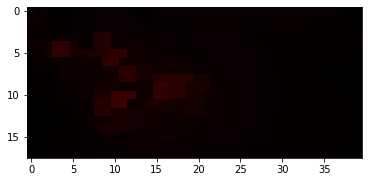

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019283.h10v04.001.2019284080008.h5.tiff
2019-10-10


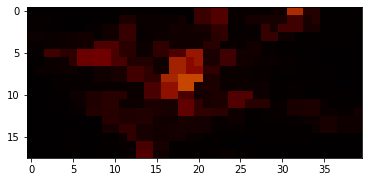

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019284.h10v04.001.2019285094114.h5.tiff
2019-10-11


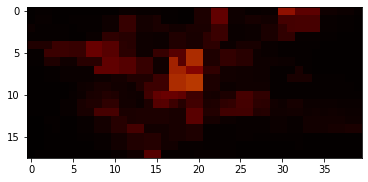

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019285.h10v04.001.2019286073808.h5.tiff
2019-10-12


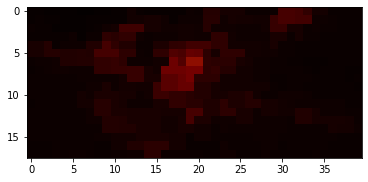

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019286.h10v04.001.2019287083935.h5.tiff
2019-10-13


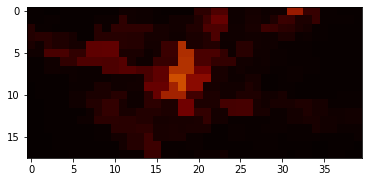

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019287.h10v04.001.2019288083704.h5.tiff
2019-10-14


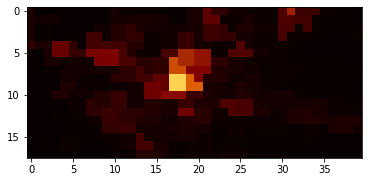

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019288.h10v04.001.2019289084837.h5.tiff
2019-10-15


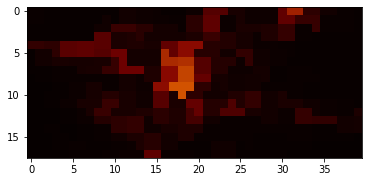

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019290.h10v04.001.2019291165907.h5.tiff
2019-10-17


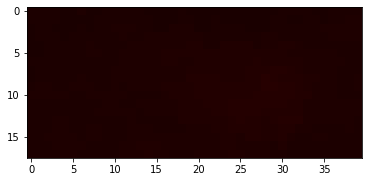

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019291.h10v04.001.2019292201619.h5.tiff
2019-10-18


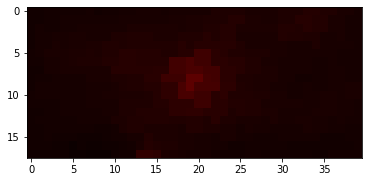

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019292.h10v04.001.2019293233034.h5.tiff
2019-10-19


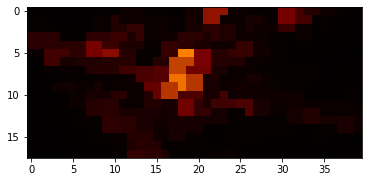

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019293.h10v04.001.2019294213150.h5.tiff
2019-10-20


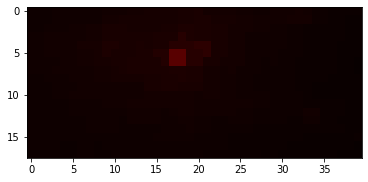

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019294.h10v04.001.2019298141956.h5.tiff
2019-10-21


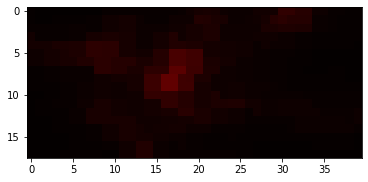

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019295.h10v04.001.2019299082650.h5.tiff
2019-10-22


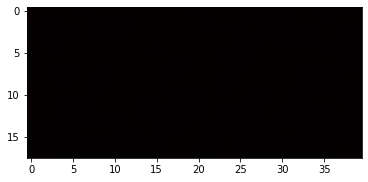

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019296.h10v04.001.2019299093401.h5.tiff
2019-10-23


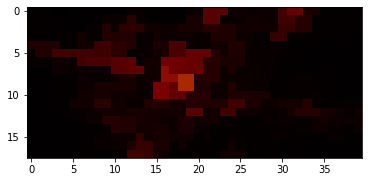

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019297.h10v04.001.2019299100240.h5.tiff
2019-10-24


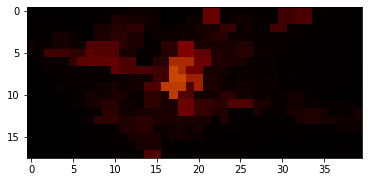

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019298.h10v04.001.2019300005238.h5.tiff
2019-10-25


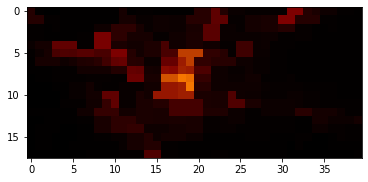

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019299.h10v04.001.2019300085516.h5.tiff
2019-10-26


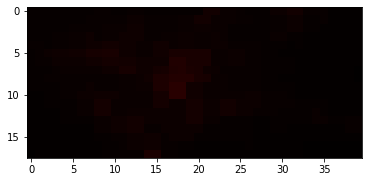

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019300.h10v04.001.2019301085104.h5.tiff
2019-10-27


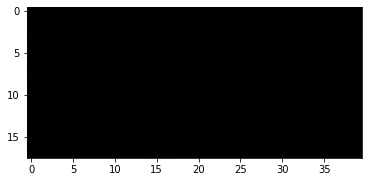

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019301.h10v04.001.2019302081019.h5.tiff
2019-10-28


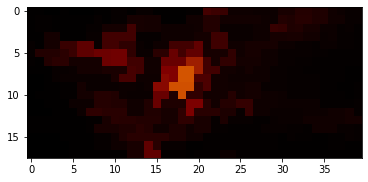

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019303.h10v04.001.2019304084058.h5.tiff
2019-10-30


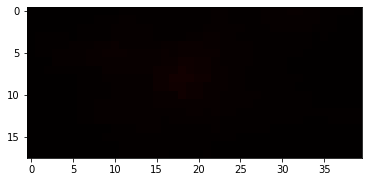

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019305.h10v04.001.2019306074640.h5.tiff
2019-11-01


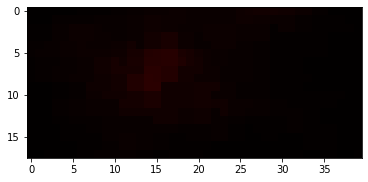

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019306.h10v04.001.2019307080410.h5.tiff
2019-11-02


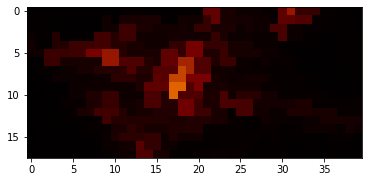

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019307.h10v04.001.2019308092521.h5.tiff
2019-11-03


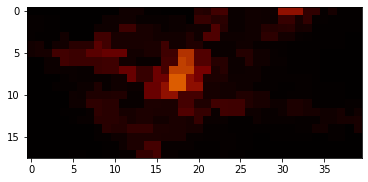

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019309.h10v04.001.2019310075820.h5.tiff
2019-11-05


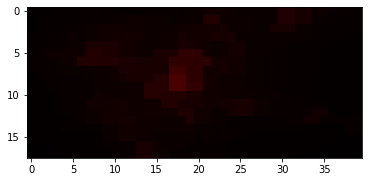

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019310.h10v04.001.2019311073813.h5.tiff
2019-11-06


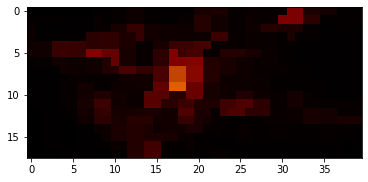

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019312.h10v04.001.2019313072656.h5.tiff
2019-11-08


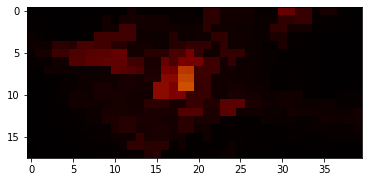

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019313.h10v04.001.2019314084400.h5.tiff
2019-11-09


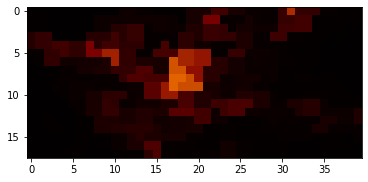

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019314.h10v04.001.2019315083714.h5.tiff
2019-11-10


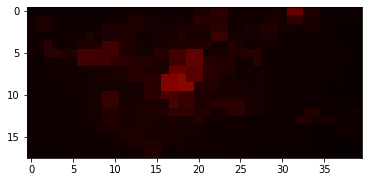

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019315.h10v04.001.2019316080513.h5.tiff
2019-11-11


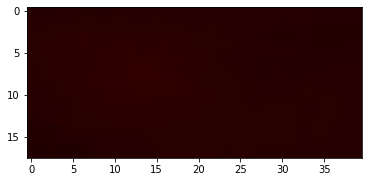

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019318.h10v04.001.2019319084431.h5.tiff
2019-11-14


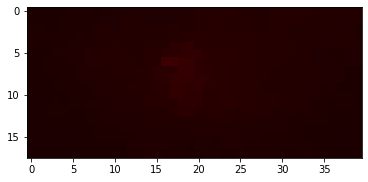

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019319.h10v04.001.2019320092306.h5.tiff
2019-11-15


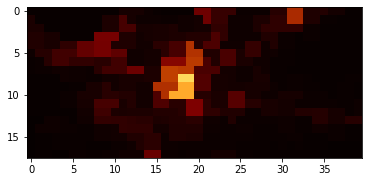

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019320.h10v04.001.2019321081231.h5.tiff
2019-11-16


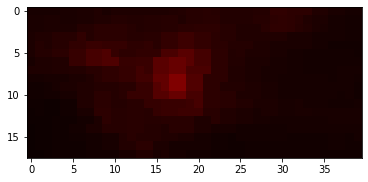

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019321.h10v04.001.2019322213737.h5.tiff
2019-11-17


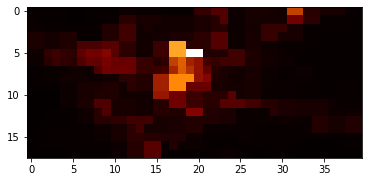

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019322.h10v04.001.2019323074713.h5.tiff
2019-11-18


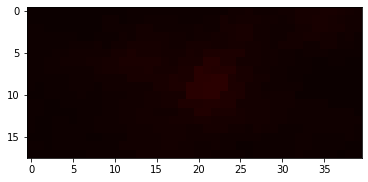

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019323.h10v04.001.2019324091337.h5.tiff
2019-11-19


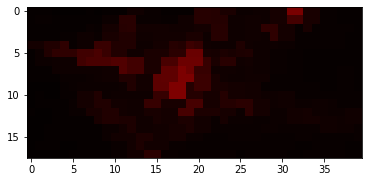

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019325.h10v04.001.2019326164308.h5.tiff
2019-11-21


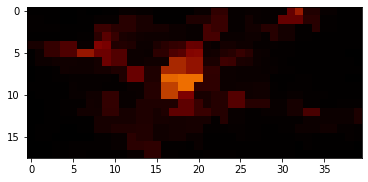

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019326.h10v04.001.2019327112538.h5.tiff
2019-11-22


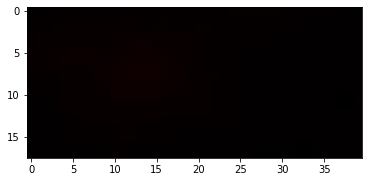

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019327.h10v04.001.2019329230945.h5.tiff
2019-11-23


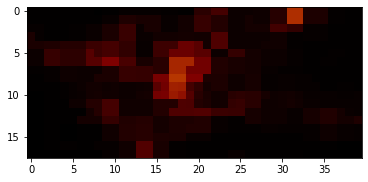

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019328.h10v04.001.2019336194150.h5.tiff
2019-11-24


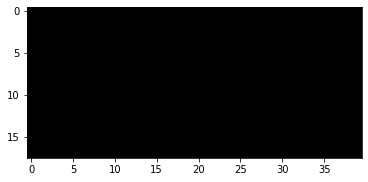

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019329.h10v04.001.2019336201955.h5.tiff
2019-11-25


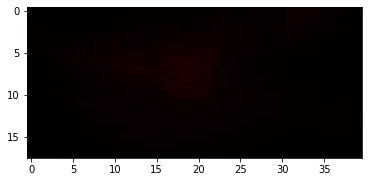

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019331.h10v04.001.2019336142905.h5.tiff
2019-11-27


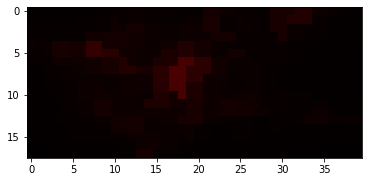

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019332.h10v04.001.2019336222915.h5.tiff
2019-11-28


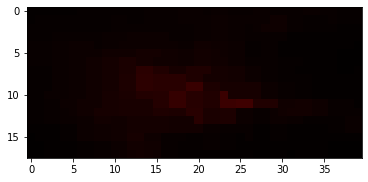

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019333.h10v04.001.2019336230451.h5.tiff
2019-11-29


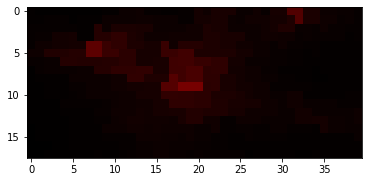

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019335.h10v04.001.2019337175849.h5.tiff
2019-12-01


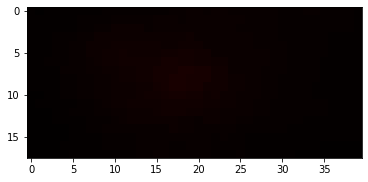

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019336.h10v04.001.2019337225256.h5.tiff
2019-12-02


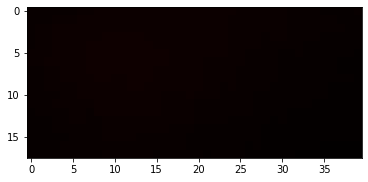

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019337.h10v04.001.2019338080921.h5.tiff
2019-12-03


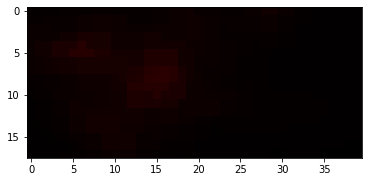

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019338.h10v04.001.2019339073751.h5.tiff
2019-12-04


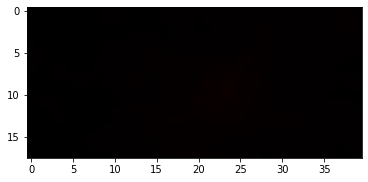

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019339.h10v04.001.2019340082712.h5.tiff
2019-12-05


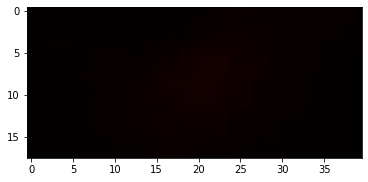

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019340.h10v04.001.2019341084258.h5.tiff
2019-12-06


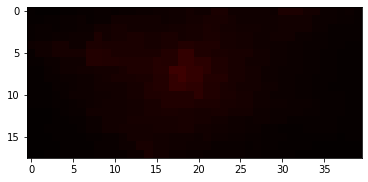

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019341.h10v04.001.2019342080358.h5.tiff
2019-12-07


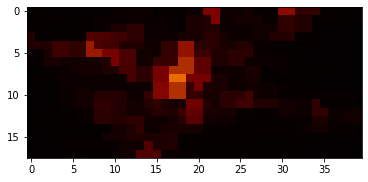

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019342.h10v04.001.2019343074404.h5.tiff
2019-12-08


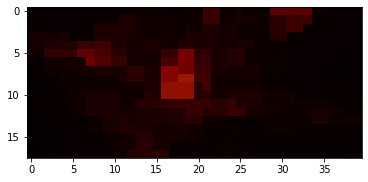

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019343.h10v04.001.2019344073633.h5.tiff
2019-12-09


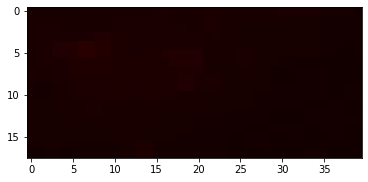

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019344.h10v04.001.2019345194534.h5.tiff
2019-12-10


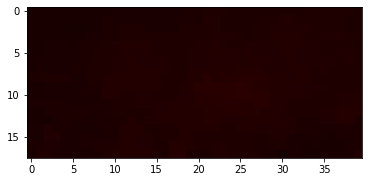

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019345.h10v04.001.2019346164659.h5.tiff
2019-12-11


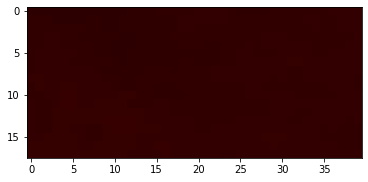

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019346.h10v04.001.2019347084008.h5.tiff
2019-12-12


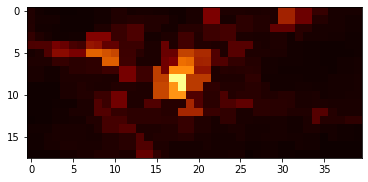

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019347.h10v04.001.2019348080451.h5.tiff
2019-12-13


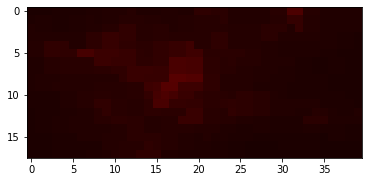

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019348.h10v04.001.2019349080449.h5.tiff
2019-12-14


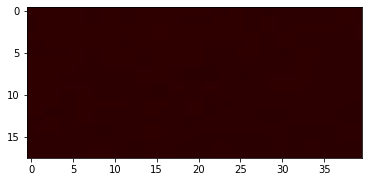

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019349.h10v04.001.2019350074302.h5.tiff
2019-12-15


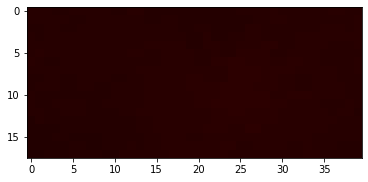

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019350.h10v04.001.2019351085014.h5.tiff
2019-12-16


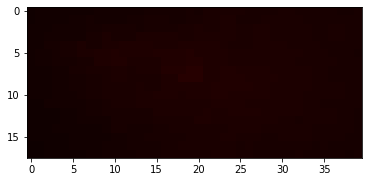

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019351.h10v04.001.2019352083842.h5.tiff
2019-12-17


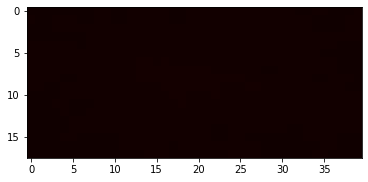

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019354.h10v04.001.2019355071356.h5.tiff
2019-12-20


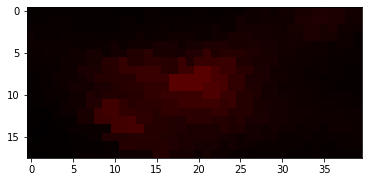

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019355.h10v04.001.2019356083611.h5.tiff
2019-12-21


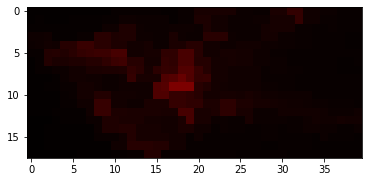

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019356.h10v04.001.2019357211249.h5.tiff
2019-12-22


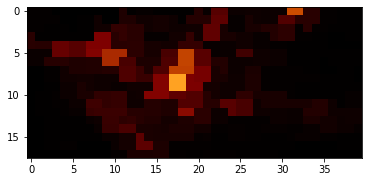

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019357.h10v04.001.2019358082435.h5.tiff
2019-12-23


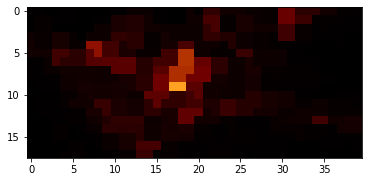

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019358.h10v04.001.2019359081913.h5.tiff
2019-12-24


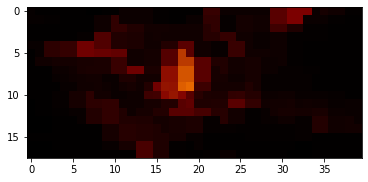

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019359.h10v04.001.2019360072503.h5.tiff
2019-12-25


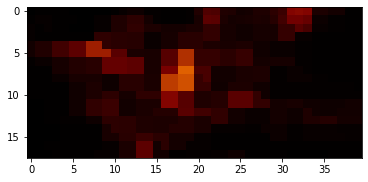

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019360.h10v04.001.2020002202936.h5.tiff
2019-12-26


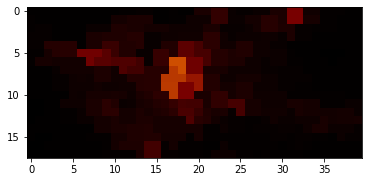

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019361.h10v04.001.2020002213633.h5.tiff
2019-12-27


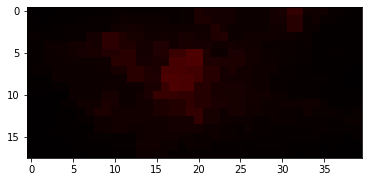

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019362.h10v04.001.2020002205915.h5.tiff
2019-12-28


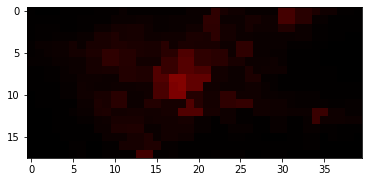

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019363.h10v04.001.2020003101107.h5.tiff
2019-12-29


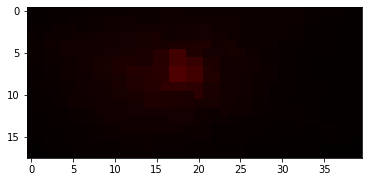

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019364.h10v04.001.2020003120813.h5.tiff
2019-12-30


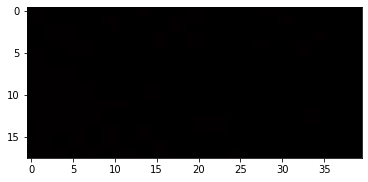

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2019365.h10v04.001.2020003234105.h5.tiff
2019-12-31


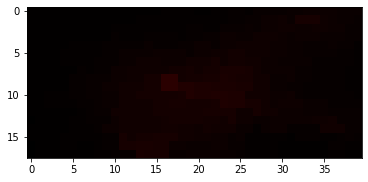

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020001.h10v04.001.2020003093022.h5.tiff
2020-01-01


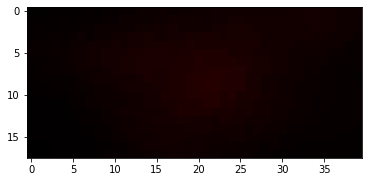

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020002.h10v04.001.2020004081524.h5.tiff
2020-01-02


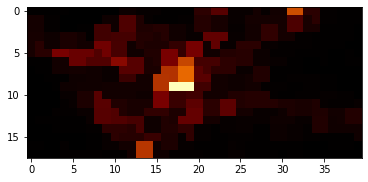

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020003.h10v04.001.2020007043242.h5.tiff
2020-01-03


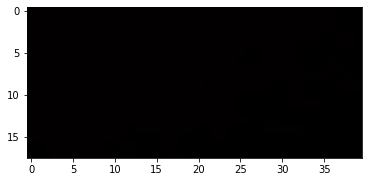

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020004.h10v04.001.2020007175826.h5.tiff
2020-01-04


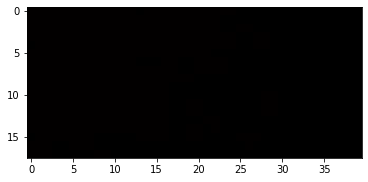

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020005.h10v04.001.2020008022402.h5.tiff
2020-01-05


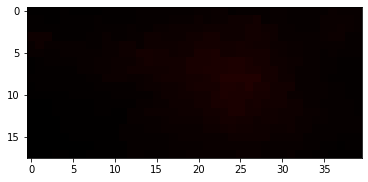

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020006.h10v04.001.2020029060554.h5.tiff
2020-01-06


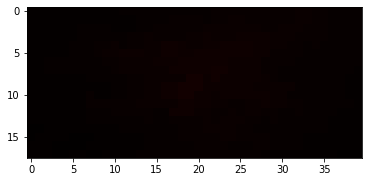

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020007.h10v04.001.2020035223559.h5.tiff
2020-01-07


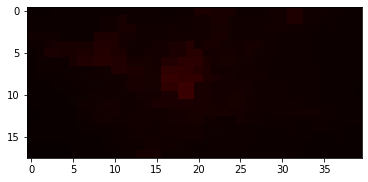

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020008.h10v04.001.2020056211757.h5.tiff
2020-01-08


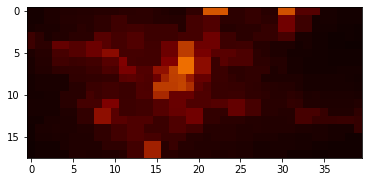

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020009.h10v04.001.2020056044407.h5.tiff
2020-01-09


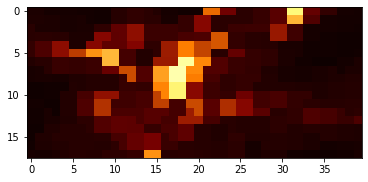

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020010.h10v04.001.2020056054618.h5.tiff
2020-01-10


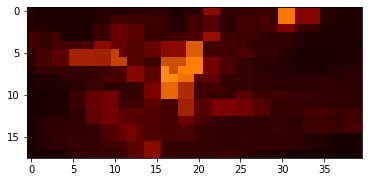

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020011.h10v04.001.2020052154936.h5.tiff
2020-01-11


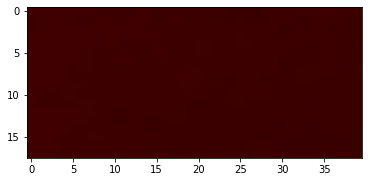

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020012.h10v04.001.2020052171603.h5.tiff
2020-01-12


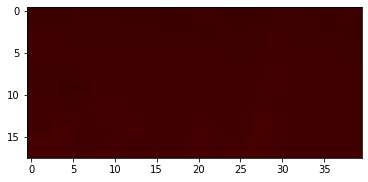

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020013.h10v04.001.2020052220927.h5.tiff
2020-01-13


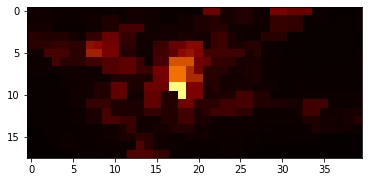

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020014.h10v04.001.2020052232343.h5.tiff
2020-01-14


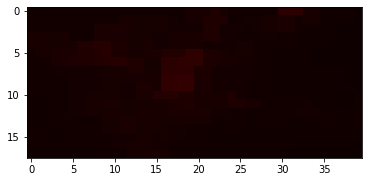

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020015.h10v04.001.2020051191119.h5.tiff
2020-01-15


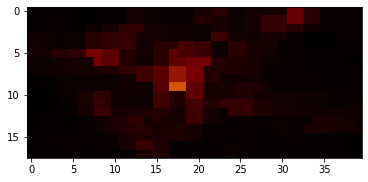

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020016.h10v04.001.2020051200707.h5.tiff
2020-01-16


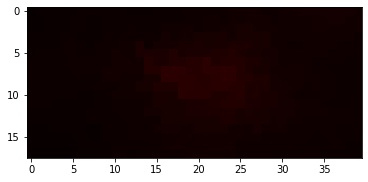

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020017.h10v04.001.2020053003758.h5.tiff
2020-01-17


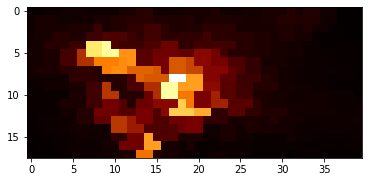

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020018.h10v04.001.2020053040333.h5.tiff
2020-01-18


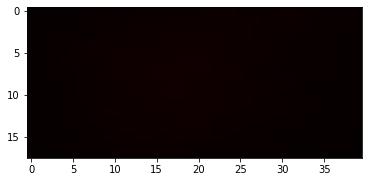

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020019.h10v04.001.2020053063906.h5.tiff
2020-01-19


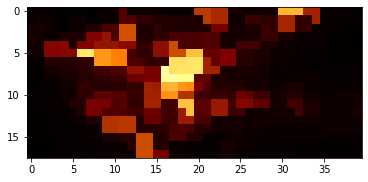

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020020.h10v04.001.2020053112323.h5.tiff
2020-01-20


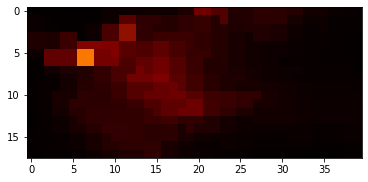

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020021.h10v04.001.2020053143005.h5.tiff
2020-01-21


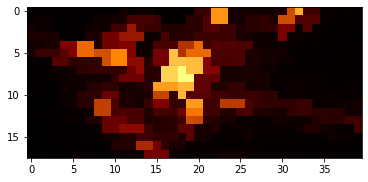

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020022.h10v04.001.2020053171157.h5.tiff
2020-01-22


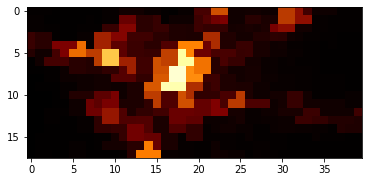

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020024.h10v04.001.2020053190615.h5.tiff
2020-01-24


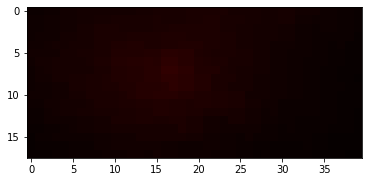

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020025.h10v04.001.2020053194901.h5.tiff
2020-01-25


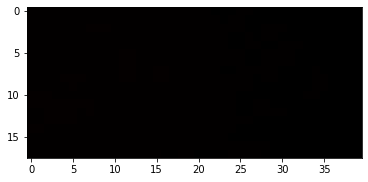

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020026.h10v04.001.2020053222316.h5.tiff
2020-01-26


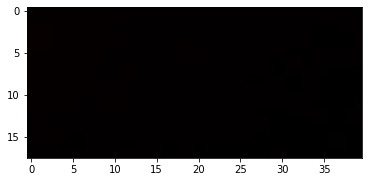

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020027.h10v04.001.2020054005304.h5.tiff
2020-01-27


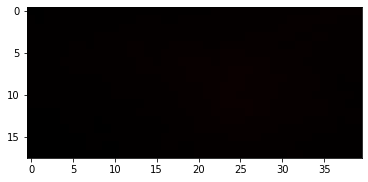

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020028.h10v04.001.2020054022720.h5.tiff
2020-01-28


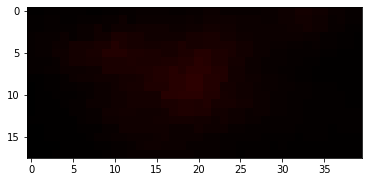

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020029.h10v04.001.2020054044927.h5.tiff
2020-01-29


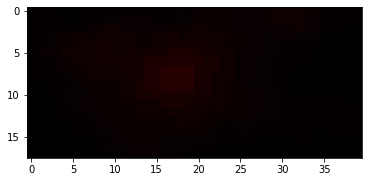

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020030.h10v04.001.2020054052944.h5.tiff
2020-01-30


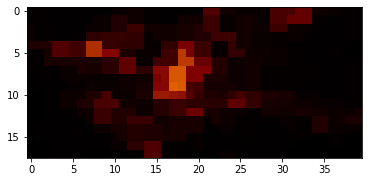

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020031.h10v04.001.2020054063853.h5.tiff
2020-01-31


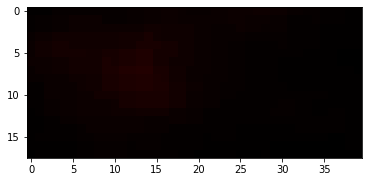

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020032.h10v04.001.2020054071651.h5.tiff
2020-02-01


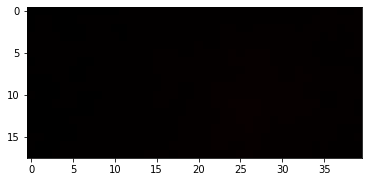

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020033.h10v04.001.2020052073304.h5.tiff
2020-02-02


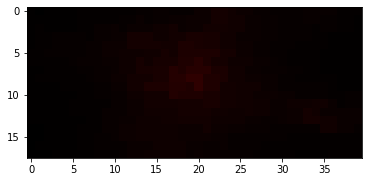

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020034.h10v04.001.2020052082123.h5.tiff
2020-02-03


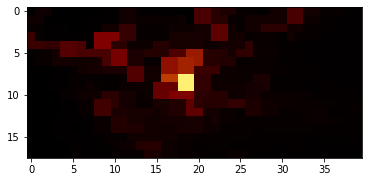

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020035.h10v04.001.2020052115219.h5.tiff
2020-02-04


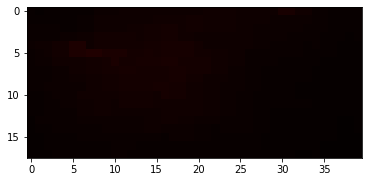

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020036.h10v04.001.2020052141616.h5.tiff
2020-02-05


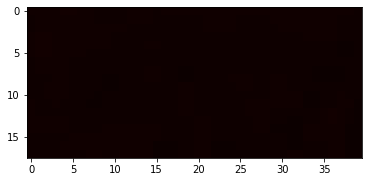

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020037.h10v04.001.2020054145205.h5.tiff
2020-02-06


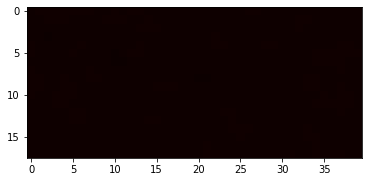

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020039.h10v04.001.2020054155431.h5.tiff
2020-02-08


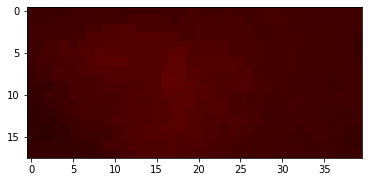

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020040.h10v04.001.2020054165804.h5.tiff
2020-02-09


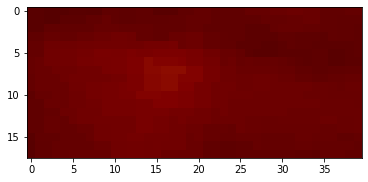

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020041.h10v04.001.2020055180743.h5.tiff
2020-02-10


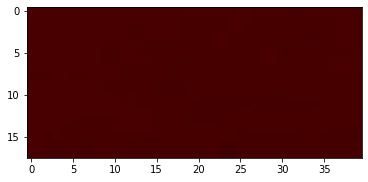

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020042.h10v04.001.2020056201947.h5.tiff
2020-02-11


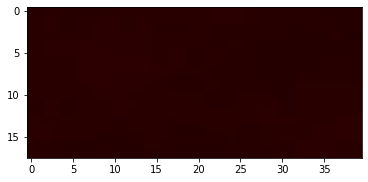

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020043.h10v04.001.2020044064529.h5.tiff
2020-02-12


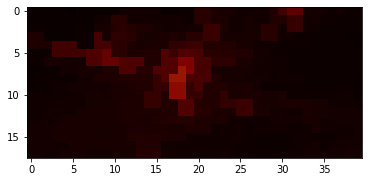

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020044.h10v04.001.2020045103738.h5.tiff
2020-02-13


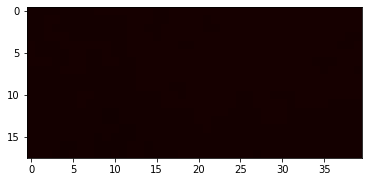

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020045.h10v04.001.2020046101241.h5.tiff
2020-02-14


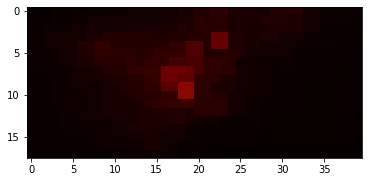

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020046.h10v04.001.2020050050716.h5.tiff
2020-02-15


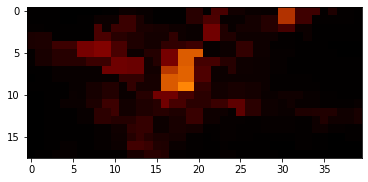

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020047.h10v04.001.2020050065033.h5.tiff
2020-02-16


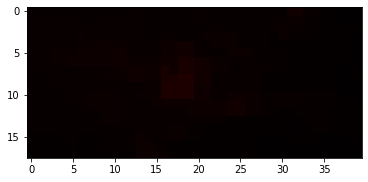

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020048.h10v04.001.2020050024910.h5.tiff
2020-02-17


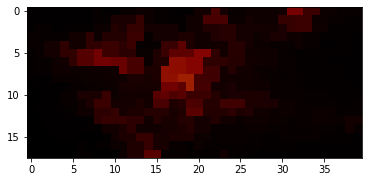

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020049.h10v04.001.2020050100950.h5.tiff
2020-02-18


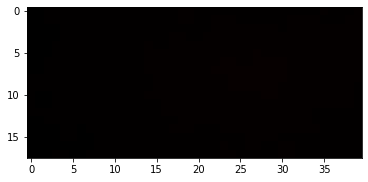

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020050.h10v04.001.2020052062215.h5.tiff
2020-02-19


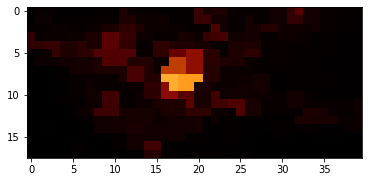

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020051.h10v04.001.2020052172745.h5.tiff
2020-02-20


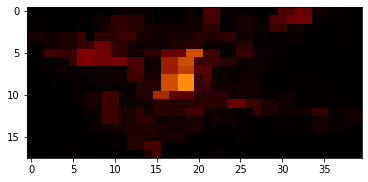

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020052.h10v04.001.2020053131351.h5.tiff
2020-02-21


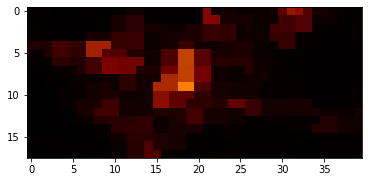

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020053.h10v04.001.2020054082630.h5.tiff
2020-02-22


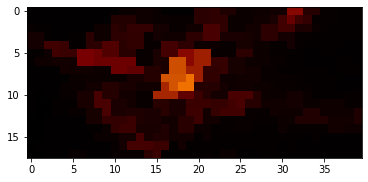

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020054.h10v04.001.2020056044055.h5.tiff
2020-02-23


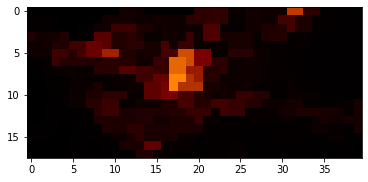

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020055.h10v04.001.2020056085628.h5.tiff
2020-02-24


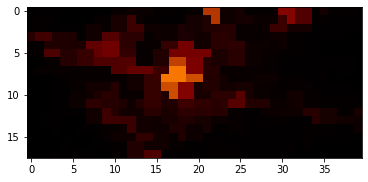

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020056.h10v04.001.2020057082146.h5.tiff
2020-02-25


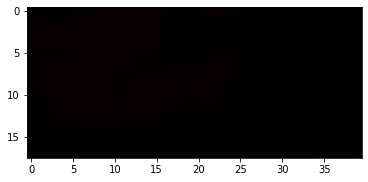

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020057.h10v04.001.2020058174612.h5.tiff
2020-02-26


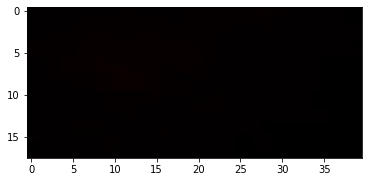

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020058.h10v04.001.2020059064208.h5.tiff
2020-02-27


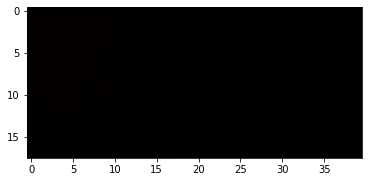

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020059.h10v04.001.2020060062619.h5.tiff
2020-02-28


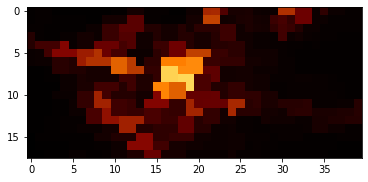

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020060.h10v04.001.2020061074401.h5.tiff
2020-02-29


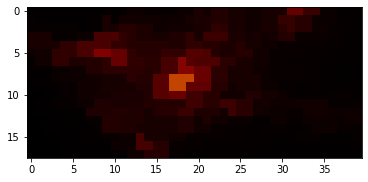

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020061.h10v04.001.2020062074148.h5.tiff
2020-03-01


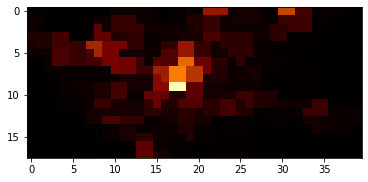

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020062.h10v04.001.2020063070420.h5.tiff
2020-03-02


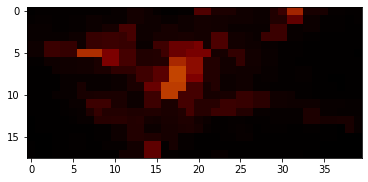

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020063.h10v04.001.2020064063535.h5.tiff
2020-03-03


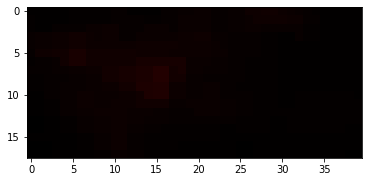

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020064.h10v04.001.2020065200253.h5.tiff
2020-03-04


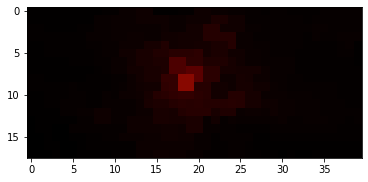

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020065.h10v04.001.2020066080331.h5.tiff
2020-03-05


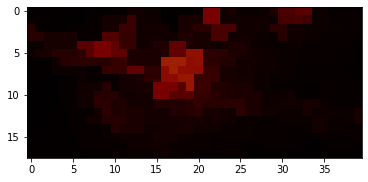

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020066.h10v04.001.2020067072614.h5.tiff
2020-03-06


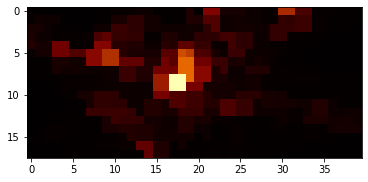

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020067.h10v04.001.2020070103707.h5.tiff
2020-03-07


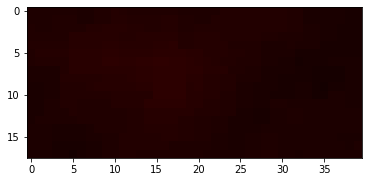

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020068.h10v04.001.2020070101452.h5.tiff
2020-03-08


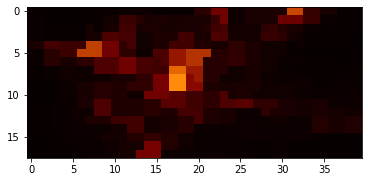

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020069.h10v04.001.2020073155652.h5.tiff
2020-03-09


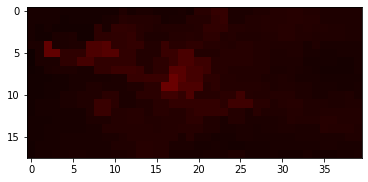

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020070.h10v04.001.2020073185837.h5.tiff
2020-03-10


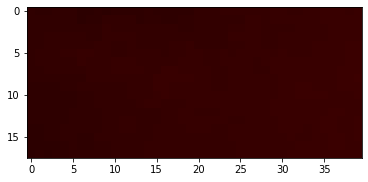

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020071.h10v04.001.2020073162415.h5.tiff
2020-03-11


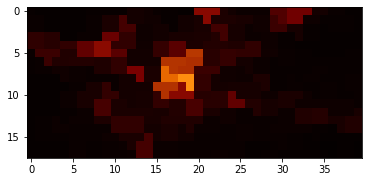

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020072.h10v04.001.2020073085839.h5.tiff
2020-03-12


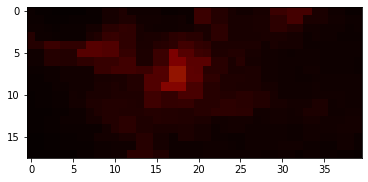

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020073.h10v04.001.2020074073513.h5.tiff
2020-03-13


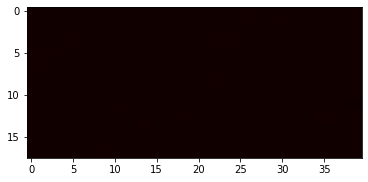

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020074.h10v04.001.2020075064657.h5.tiff
2020-03-14


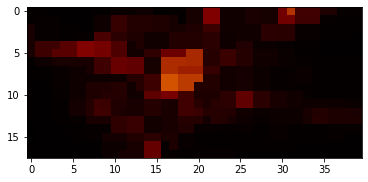

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020075.h10v04.001.2020076061746.h5.tiff
2020-03-15


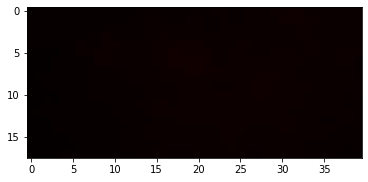

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020076.h10v04.001.2020077211047.h5.tiff
2020-03-16


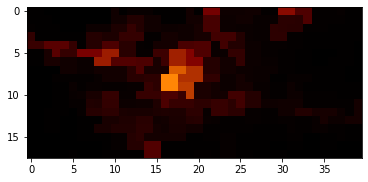

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020077.h10v04.001.2020078072743.h5.tiff
2020-03-17


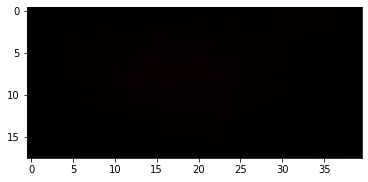

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020078.h10v04.001.2020079065420.h5.tiff
2020-03-18


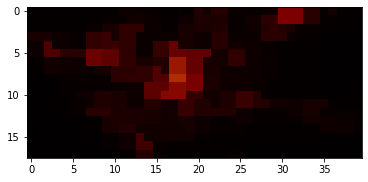

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020079.h10v04.001.2020080112308.h5.tiff
2020-03-19


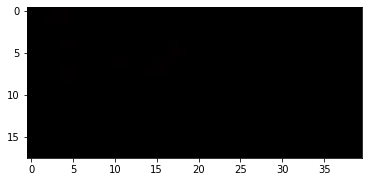

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020080.h10v04.001.2020081061544.h5.tiff
2020-03-20


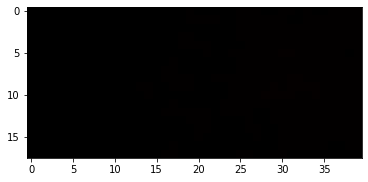

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020081.h10v04.001.2020082074605.h5.tiff
2020-03-21


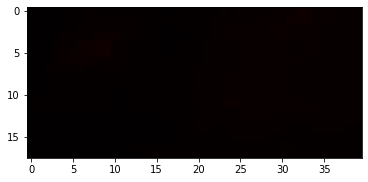

/home/ubuntu/scpa/d_DNBData_FieldsDNB_At_Sensor_Radiance_500mVNP46A1.A2020082.h10v04.001.2020083073655.h5.tiff
2020-03-22


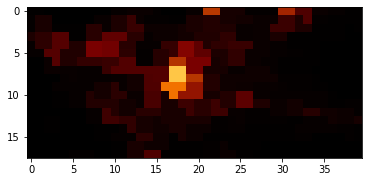

In [4]:
def getDate(path,fn,d):
    hdflayer = gdal.Open(path)
    d.append((fn,hdflayer.GetMetadata()['HDFEOS_GRIDS_VNP_Grid_DNB_RangeBeginningDate']))
    
import glob
tshapef = "/home/ubuntu/scpa/struct/PSU.shp"
tfs = glob.glob("/home/ubuntu/scpa/*Rad*")
    
d = []

for i in tfs:
    getDate(i,i,d)
    
sorted_by_date = sorted(d, key=lambda tup: tup[1])
sortedimages = [x[0] for x in sorted_by_date]

for i in sortedimages:
    print(i)
    wus = gdal.Open(i)
    print(wus.GetMetadata()['HDFEOS_GRIDS_VNP_Grid_DNB_RangeBeginningDate'])
    fm = clip_raster(wus,tshapef)
    f, ax = plt.subplots(1, figsize=(6,6))
    plt.set_cmap('afmhot')
    plt.imshow(fm[0])
    #plt.colorbar()
    plt.clim(0,2000)
    plt.show()